<a href="https://colab.research.google.com/github/Isi2000/PATTERN/blob/main/PATTERN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#data an and plotting 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import random

#torch 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms.functional as Ft

import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms
from torchvision.io import read_image
from torchsummary import summary
import torch.optim as optim
#working with dirs
import os

In [23]:
#this line of code copies the files in the PATTERN repo
#they are hd image so it may take a while
!git clone https://github.com/Isi2000/PATTERN.git

fatal: destination path 'PATTERN' already exists and is not an empty directory.


# DATASET

First the image paths and labels need to be storged in a pd DataFrame object to later be put in a custom made dataset 

In [24]:
labels_map = {0: 'NORMAL', 1:'BACTERIAL', 2:'VIRAL',}

data_dir_train = '/content/PATTERN/images/t_all'
data_dir_test = '/content/PATTERN/images/test_all'
data_dir_val = '/content/PATTERN/images/val_all'

d_train = {'img_path': os.listdir(data_dir_train)}
d_test = {'img_path': os.listdir(data_dir_test)}
d_val = {'img_path': os.listdir(data_dir_val)}

df_train = pd.DataFrame(d_train)
df_test= pd.DataFrame(d_test)
df_val = pd.DataFrame(d_val)

df_train['label'] = 0
df_test['label'] = 0
df_val['label'] = 0

#these lines work really well, BE CAREFUL BECAUSE IT GIVES A PD WARNING 

#DIOCANE
df_train.loc[df_train['img_path'].str.contains('virus'), 'label'] = 2
df_train.loc[df_train['img_path'].str.contains('bacte'), 'label'] = 1
df_test.loc[df_test['img_path'].str.contains('virus'), 'label'] = 2
df_test.loc[df_test['img_path'].str.contains('bacte'), 'label'] = 1
df_val.loc[df_val['img_path'].str.contains('virus'), 'label'] = 2
df_val.loc[df_val['img_path'].str.contains('bacte'), 'label'] = 1

print(df_train.head())
print(df_test.head())
print(df_val.head())


                       img_path  label
0     person22_bacteria_76.jpeg      1
1  person583_bacteria_2409.jpeg      1
2             IM-0444-0001.jpeg      0
3  person581_bacteria_2394.jpeg      1
4  person603_bacteria_2461.jpeg      1
                     img_path  label
0           IM-0007-0001.jpeg      0
1  person1633_virus_2829.jpeg      2
2           IM-0029-0001.jpeg      0
3       person1_virus_12.jpeg      2
4           IM-0003-0001.jpeg      0
                        img_path  label
0  person1947_bacteria_4876.jpeg      1
1      NORMAL2-IM-1431-0001.jpeg      0
2      NORMAL2-IM-1440-0001.jpeg      0
3  person1950_bacteria_4881.jpeg      1
4  person1951_bacteria_4882.jpeg      1


Transformation and Custome Image Dataset. The class is written following to pytorch standards 
(for more info see https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [25]:
#stands for pixels, it's for resizing

pix = 512

transform_1 = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Grayscale(),    
     #the resizing must be fixed according to training perf
     #224 is the standard size for resnets
     transforms.Resize(size = (pix, pix), antialias = False),
     transforms.Normalize(mean=[0.0], std=[1.0]),
     #this one is for resnet
     transforms.Lambda(lambda x: x.repeat(3,1,1)),
     ])

class CustomImageDataset(Dataset):
    def __init__(self, pd_df, img_dir, transform=None, target_transform=None):
        self.img_labels = pd_df
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

train_ = CustomImageDataset(df_train, data_dir_train, transform = transform_1)
test_ = CustomImageDataset(df_test, data_dir_test, transform = transform_1)
val_ = CustomImageDataset(df_val, data_dir_val, transform = transform_1)

Data visualization of the dataset

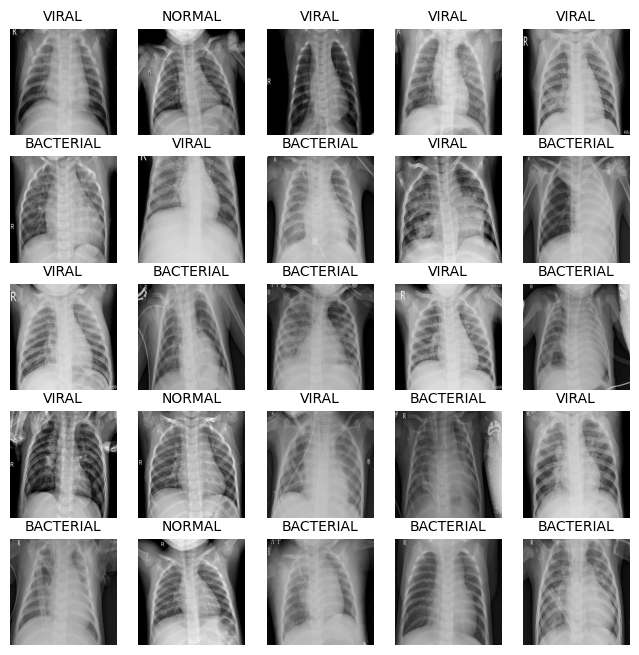

In [26]:
def plotter(data):      
    """this plots 9 images from a dataset"""
    figure = plt.figure(figsize = (8,8))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        img, label = Ft.to_pil_image(data[sample_idx][0]) , data[sample_idx][1]
        #print(img.size)
        figure.add_subplot(rows, cols, i)
        plt.axis("off")
        plt.title(labels_map[label], fontsize = 10)
        plt.imshow(img)        
    plt.show()

plotter(train_)

# Neural Network and GPU

The code below tells the program to use gpu if available. All the code written is designed to work even if the machine doesn't have a gpu

In [27]:
if torch.cuda.is_available():
    print("Congratulations, you have a GPU!")
else:
    print("PyTorch cannot see your GPU :(")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Congratulations, you have a GPU!


# Resnet
The Neural Network chosen is resnet50. It is a pretrained NN that performs really well on computer vision problem. It takes as input 3 channels 224x224 images and it classifies them into 1000 classes

In [28]:
from torchvision.models import resnet50
from torchvision.models import alexnet

net = alexnet(pretrained=True).to(torch.device('cuda'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The input channels can be fixed with a simple transformation. For what concerns the output, the output of the net can be connected to a fully connected layer with label 3 outputs

In [29]:
#num_ftrs = net.fc.in_features
#net.fc = nn.Sequential(nn.Linear(num_ftrs, 3)).to(torch.device('cuda'))
#print(net.classifier[-1])
summary(net, (3, 512,512), device = 'cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

# Training and Testing

In [30]:

loss_fn = torch.nn.NLLLoss()
m = nn.LogSoftmax(dim=1)

#Adam may be too strong
optimizer = optim.AdamW(net.parameters(), lr=1e-6, weight_decay=1e-5)

train_loader = DataLoader(train_, batch_size=50, shuffle=True)
test_loader = DataLoader(test_, batch_size=50, shuffle=True)
val_loader = DataLoader(val_, batch_size=10, shuffle=True)



def train(model, device, train_loader, optimizer, epoch, freq=20):
    model.train()
    epoch_loss = 0    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(m(output), target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % freq == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
        
        epoch_loss += loss.item()
            
    return epoch_loss / len(train_loader)


def test(model, device, test_loader):
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(m(output), target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)  
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return test_loss, (100. * correct / len(test_loader.dataset))

In [31]:
train_losses = []
test_losses = []
test_accuracies = []

num_epochs = 15
best_params = net.state_dict()
best_accuracy = 0

for epoch in range(1, num_epochs + 1):
    train_losses.append(train(net, device, train_loader, optimizer, epoch))
    test_loss, test_accuracy = test(net, device, test_loader)

    # model selection
    if test_accuracy >= best_accuracy:
        best_accuracy = test_accuracy
        best_params = net.state_dict()

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Train Epoch: 1 [0/5216 (0%)]	Loss: 8.469363
Train Epoch: 1 [1000/5216 (19%)]	Loss: 7.581916
Train Epoch: 1 [2000/5216 (38%)]	Loss: 6.714430
Train Epoch: 1 [3000/5216 (57%)]	Loss: 5.384915
Train Epoch: 1 [4000/5216 (76%)]	Loss: 4.929275
Train Epoch: 1 [5000/5216 (95%)]	Loss: 4.258276

Test set: Average loss: 3.8178, Accuracy: 233/624 (37%)

Train Epoch: 2 [0/5216 (0%)]	Loss: 3.721694
Train Epoch: 2 [1000/5216 (19%)]	Loss: 2.305030
Train Epoch: 2 [2000/5216 (38%)]	Loss: 2.698564
Train Epoch: 2 [3000/5216 (57%)]	Loss: 2.115511
Train Epoch: 2 [4000/5216 (76%)]	Loss: 1.596076
Train Epoch: 2 [5000/5216 (95%)]	Loss: 1.433818

Test set: Average loss: 1.3493, Accuracy: 262/624 (42%)

Train Epoch: 3 [0/5216 (0%)]	Loss: 1.223233
Train Epoch: 3 [1000/5216 (19%)]	Loss: 1.223161
Train Epoch: 3 [2000/5216 (38%)]	Loss: 1.014532
Train Epoch: 3 [3000/5216 (57%)]	Loss: 1.087433
Train Epoch: 3 [4000/5216 (76%)]	Loss: 1.158806
Train Epoch: 3 [5000/5216 (95%)]	Loss: 1.115327

Test set: Average loss: 0.8436,

# RESULTS

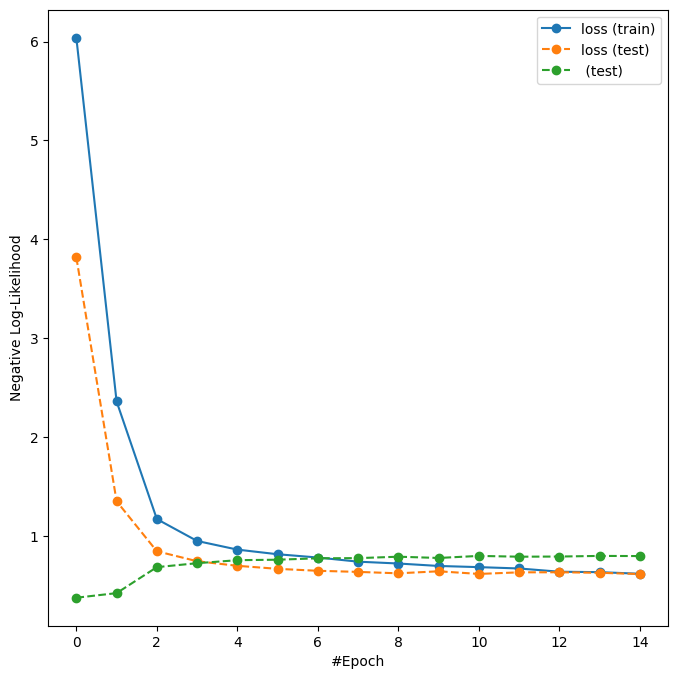

In [34]:

plt.figure(figsize=(8, 8))
a = []
for i in test_accuracies:
  a.append(i / 100)

plt.plot(train_losses, marker='o', label='loss (train)')
plt.plot(test_losses, marker='o', linestyle='dashed', label='loss (test)')
plt.plot(a, marker='o', linestyle='dashed', label=' (test)')



plt.xlabel('#Epoch')
plt.ylabel('Negative Log-Likelihood')

plt.legend()
plt.show()


In [33]:
# resume best model
net.load_state_dict(best_params)
best_accuracy

79.6474358974359